In [26]:
####
import os
os.getcwd()
import numpy as np
import sys
import multiprocessing  
# os.chdir('/home/amb2022/clusterCCA_revision1/clusterCCA/utils/subspace-clustering-master')
# import cluster
# os.chdir('/athena/listonlab/store/amb2022/PCMF/')
os.chdir('/Users/amandabuch/Documents/clusterCCA/PCMF/')

import pandas as pd
saving_dir_fullpath='/Users/amandabuch/Documents/clusterCCA/PCMF/results/'
# saving_dir_fullpath='/athena/listonlab/scratch/amb2022/PCMF/results/'

import mosek
import cvxpy as cp
import time
from itertools import combinations
from admm_utils import prox as cprox
from pcmf import pcmf_full, pcmf_approx_uV
from sklearn.preprocessing import StandardScaler

import argparse

import sys
from datetime import datetime as dt
import pandas as pd
from shutil import copyfile

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict
np.random.seed(1234)



In [92]:
def load_GbmBreastLungCancergenomics_geneProteinMIRNA(data_path='data/'):
    import pandas as pd
    # Load GbmBreastLungCancer dataset
    # GENES
#     gbm = pd.read_csv(os.path.join(data_path, 'gbm_Z_gene.txt'), sep='\t', header=0)
#     gbm = pd.read_csv(os.path.join(data_path, 'gbm_Z_gene.txt'), sep='\t', header=0)
    lung = pd.read_csv(os.path.join(data_path, 'lung_Z_gene.txt'), sep='\t', header=0)
    breast = pd.read_csv(os.path.join(data_path, 'breast_Z_gene.txt'), sep='\t', header=0)
    labels = np.hstack((np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
#     labels = np.hstack((np.repeat('gbm',gbm.shape[0]),np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
#     gbm_T = gbm.T
#     gbm_T['variables'] = gbm.columns
    lung_T = lung.T
    lung_T['variables'] = lung.columns
    breast_T = breast.T
    breast_T['variables'] = breast.columns
    data_T = pd.merge(lung_T,breast_T,on='variables')
#     data_T = pd.merge(gbm_T,pd.merge(lung_T,breast_T,on='variables'),on='variables')
    data = data_T.drop(columns='variables').T
    data.columns = data_T['variables']

    data_gene = data
    labels_gene = labels
    del data, data_T, labels, lung, breast, lung_T, breast_T
#     del data, data_T, labels, gbm, lung, breast, gbm_T, lung_T, breast_T
    
    # PROTEINS
    gbm = pd.read_csv(os.path.join(data_path, 'gbm_Z_methy.txt'), sep='\t', header=0)
    lung = pd.read_csv(os.path.join(data_path, 'lung_Z_methy.txt'), sep='\t', header=0)
    breast = pd.read_csv(os.path.join(data_path, 'breast_Z_methy.txt'), sep='\t', header=0)
    labels = np.hstack((np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
#     labels = np.hstack((np.repeat('gbm',gbm.shape[0]),np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
#     gbm_T = gbm.T
#     gbm_T['variables'] = gbm.columns
    lung_T = lung.T
    lung_T['variables'] = lung.columns
    breast_T = breast.T
    breast_T['variables'] = breast.columns
    data_T = pd.merge(lung_T,breast_T,on='variables')
#     data_T = pd.merge(gbm_T,pd.merge(lung_T,breast_T,on='variables'),on='variables')
    data = data_T.drop(columns='variables').T
    data.columns = data_T['variables']

    data_protein = data
    labels_protein = labels
    del data, data_T, labels, lung, breast, lung_T, breast_T
#     del data, data_T, labels, gbm, lung, breast, gbm_T, lung_T, breast_T
  
    # miRNAs
    gbm = pd.read_csv(os.path.join(data_path, 'gbm_Z_mirna.txt'), sep='\t', header=0)
    lung = pd.read_csv(os.path.join(data_path, 'lung_Z_mirna.txt'), sep='\t', header=0)
    breast = pd.read_csv(os.path.join(data_path, 'breast_Z_mirna.txt'), sep='\t', header=0)
    labels = np.hstack((np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
#     labels = np.hstack((np.repeat('gbm',gbm.shape[0]),np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
#     gbm_T = gbm.T
#     gbm_T['variables'] = gbm.columns
    lung_T = lung.T
    lung_T['variables'] = lung.columns
    breast_T = breast.T
    breast_T['variables'] = breast.columns
    data_T = pd.merge(lung_T,breast_T,on='variables')
#     data_T = pd.merge(gbm_T,pd.merge(lung_T,breast_T,on='variables'),on='variables')
    data = data_T.drop(columns='variables').T
    data.columns = data_T['variables']

    data_mirna = data
    labels_mirna = labels
    del data, data_T, labels, lung, breast, lung_T, breast_T
#     del data, data_T, labels, gbm, lung, breast, gbm_T, lung_T, breast_T


    return data_gene, labels_gene, data_protein, labels_protein, data_mirna, labels_mirna



def load_GbmBreastLungCancergenomics_geneProteinMIRNA_3class(data_path='data/'):
    import pandas as pd
    # Load GbmBreastLungCancer dataset
    # GENES
    kidney = pd.read_csv(os.path.join(data_path, 'kidney_Z_gene.txt'), sep='\t', header=0)
    lung = pd.read_csv(os.path.join(data_path, 'lung_Z_gene.txt'), sep='\t', header=0)
    breast = pd.read_csv(os.path.join(data_path, 'breast_Z_gene.txt'), sep='\t', header=0)
    labels = np.hstack((np.repeat('kidney',kidney.shape[0]),np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
    kidney_T = kidney.T
    kidney_T['variables'] = kidney.columns
    lung_T = lung.T
    lung_T['variables'] = lung.columns
    breast_T = breast.T
    breast_T['variables'] = breast.columns
    data_T = pd.merge(kidney_T,pd.merge(lung_T,breast_T,on='variables'),on='variables')
    data = data_T.drop(columns='variables').T
    data.columns = data_T['variables']

    data_gene = data
    labels_gene = labels
    del data, data_T, labels, kidney, lung, breast, kidney_T, lung_T, breast_T

  
    # miRNAs
    kidney = pd.read_csv(os.path.join(data_path, 'kidney_Z_mirna.txt'), sep='\t', header=0)
    lung = pd.read_csv(os.path.join(data_path, 'lung_Z_mirna.txt'), sep='\t', header=0)
    breast = pd.read_csv(os.path.join(data_path, 'breast_Z_mirna.txt'), sep='\t', header=0)
    labels = np.hstack((np.repeat('kidney',kidney.shape[0]),np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
    kidney_T = kidney.T
    kidney_T['variables'] = kidney.columns
    lung_T = lung.T
    lung_T['variables'] = lung.columns
    breast_T = breast.T
    breast_T['variables'] = breast.columns
    data_T = pd.merge(kidney_T,pd.merge(lung_T,breast_T,on='variables'),on='variables')
    data = data_T.drop(columns='variables').T
    data.columns = data_T['variables']
    
    data_mirna = data
    labels_mirna = labels
    del data, data_T, labels, kidney, lung, breast, kidney_T, lung_T, breast_T


    return data_gene, labels_gene, data_mirna, labels_mirna


In [93]:
# data_gene, labels_gene, data_protein, labels_protein, data_mirna, labels_mirna = load_GbmBreastLungCancergenomics_geneProteinMIRNA(data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/')  
# print('Gene',data_gene.shape,labels_gene.shape, 'Protein',data_protein.shape,labels_protein.shape, 'miRNA',data_mirna.shape,labels_mirna.shape)

data_gene, labels_gene, data_mirna, labels_mirna = load_GbmBreastLungCancergenomics_geneProteinMIRNA_3class(data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/')  
print('Gene',data_gene.shape,labels_gene.shape, 'miRNA',data_mirna.shape,labels_mirna.shape)
    
    

Gene (333, 10299) (333,) miRNA (333, 302) (333,)


In [94]:
from p3ca import admm_CCA_new, path_plot
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
    


In [95]:
rows_skip = 3
data_gene_subset = data_gene[::rows_skip]
data_protein_subset = data_protein[::rows_skip]
data_mirna_subset = data_mirna[::rows_skip]

labels_subset = labels_gene[::rows_skip]
X_c = data_gene_subset.to_numpy()[:,0:10000]
Y_c = data_mirna_subset.to_numpy()
true_clusters = labels_subset
print(X_c.shape, Y_c.shape, true_clusters.shape)


# scaler = StandardScaler()
# scaler.fit(X_c)
# X_c = scaler.transform(X_c)
# X_c = np.hstack((X_c,np.ones((X_c.shape[0],1))))


# scaler = StandardScaler()
# scaler.fit(Y_c)
# Y_c = scaler.transform(Y_c)
# Y_c = np.hstack((Y_c,np.ones((Y_c.shape[0],1))))

print(X_c.shape, Y_c.shape, true_clusters.shape)




(111, 10000) (111, 302) (111,)
(111, 10000) (111, 302) (111,)


In [96]:
# penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-5,500,10))[::-1])) #np.exp(np.linspace(-18,4,5))[::-1]
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-5,150,200))[::-1])) #np.exp(np.linspace(-18,4,5))[::-1]
# penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-5,50,10))[::-1])) #np.exp(np.linspace(-18,4,5))[::-1]
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-5,200,10))[::-1])) #np.exp(np.linspace(-18,4,5))[::-1]

# Run PCMF
tic = time.time()
neighbors = 15
gauss_coef = 2.0
rho = 1.0
pcmf_type = 'P3CA'
save_path = saving_dir_fullpath+pcmf_type+'_GbmBreastLungCancer_genomics_run_gausscoef'+str(gauss_coef)+'_neighbors'+str(neighbors)+'_rho'+str(rho)+'.npz'
output_file = saving_dir_fullpath+pcmf_type+'_GbmBreastLungCancer_genomics_run_gausscoef'+str(gauss_coef)+'_neighbors'+str(neighbors)+'_rho'+str(rho)+'.txt'
print(save_path)

tic = time.time()
U_list, V_list = admm_CCA_new(X_c, Y_c, penalty_list, numba=True, rho=rho, gauss_coef=gauss_coef, neighbors=neighbors, admm_iters = 3, cca_iters=3, verb=True, weights='Gaussian')
toc = time.time() - tic
print("Running length P3CA:", toc)



# A, U, S, V = pcmf_full(X_c, penalty_list, rho=rho, admm_iters = admm_iters, weights=weights, gauss_coef=gauss_coef, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=output_file)
# toc = time.time() - tic
# np.savez(save_path, pcmf_type=pcmf_type, X_c=X_c, true_clusters=true_clusters, A=A, V=V, U=U, S=S, runtime=toc, penalty_list=penalty_list, rho=rho, admm_iters = admm_iters, weights=weights, gauss_coef=gauss_coef, neighbors=neighbors, scale_data=True, intercept=True) 




/Users/amandabuch/Documents/clusterCCA/PCMF/results/P3CA_GbmBreastLungCancer_genomics_run_gausscoef2.0_neighbors15_rho1.0.npz
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 7.22597e+86...[ 12 ] 9.26047e+76...[ 13 ] 1.18678e+67...[ 14 ] 1.52092e+57...[ 15 ] 1.94914e+47...[ 16 ] 2.49793e+37...[ 17 ] 3.20123e+27...[ 18 ] 4.10255e+17...[ 19 ] 5.25764e+07...[ 20 ] 6.73795e-03...Running length P3CA: 466.25073885917664


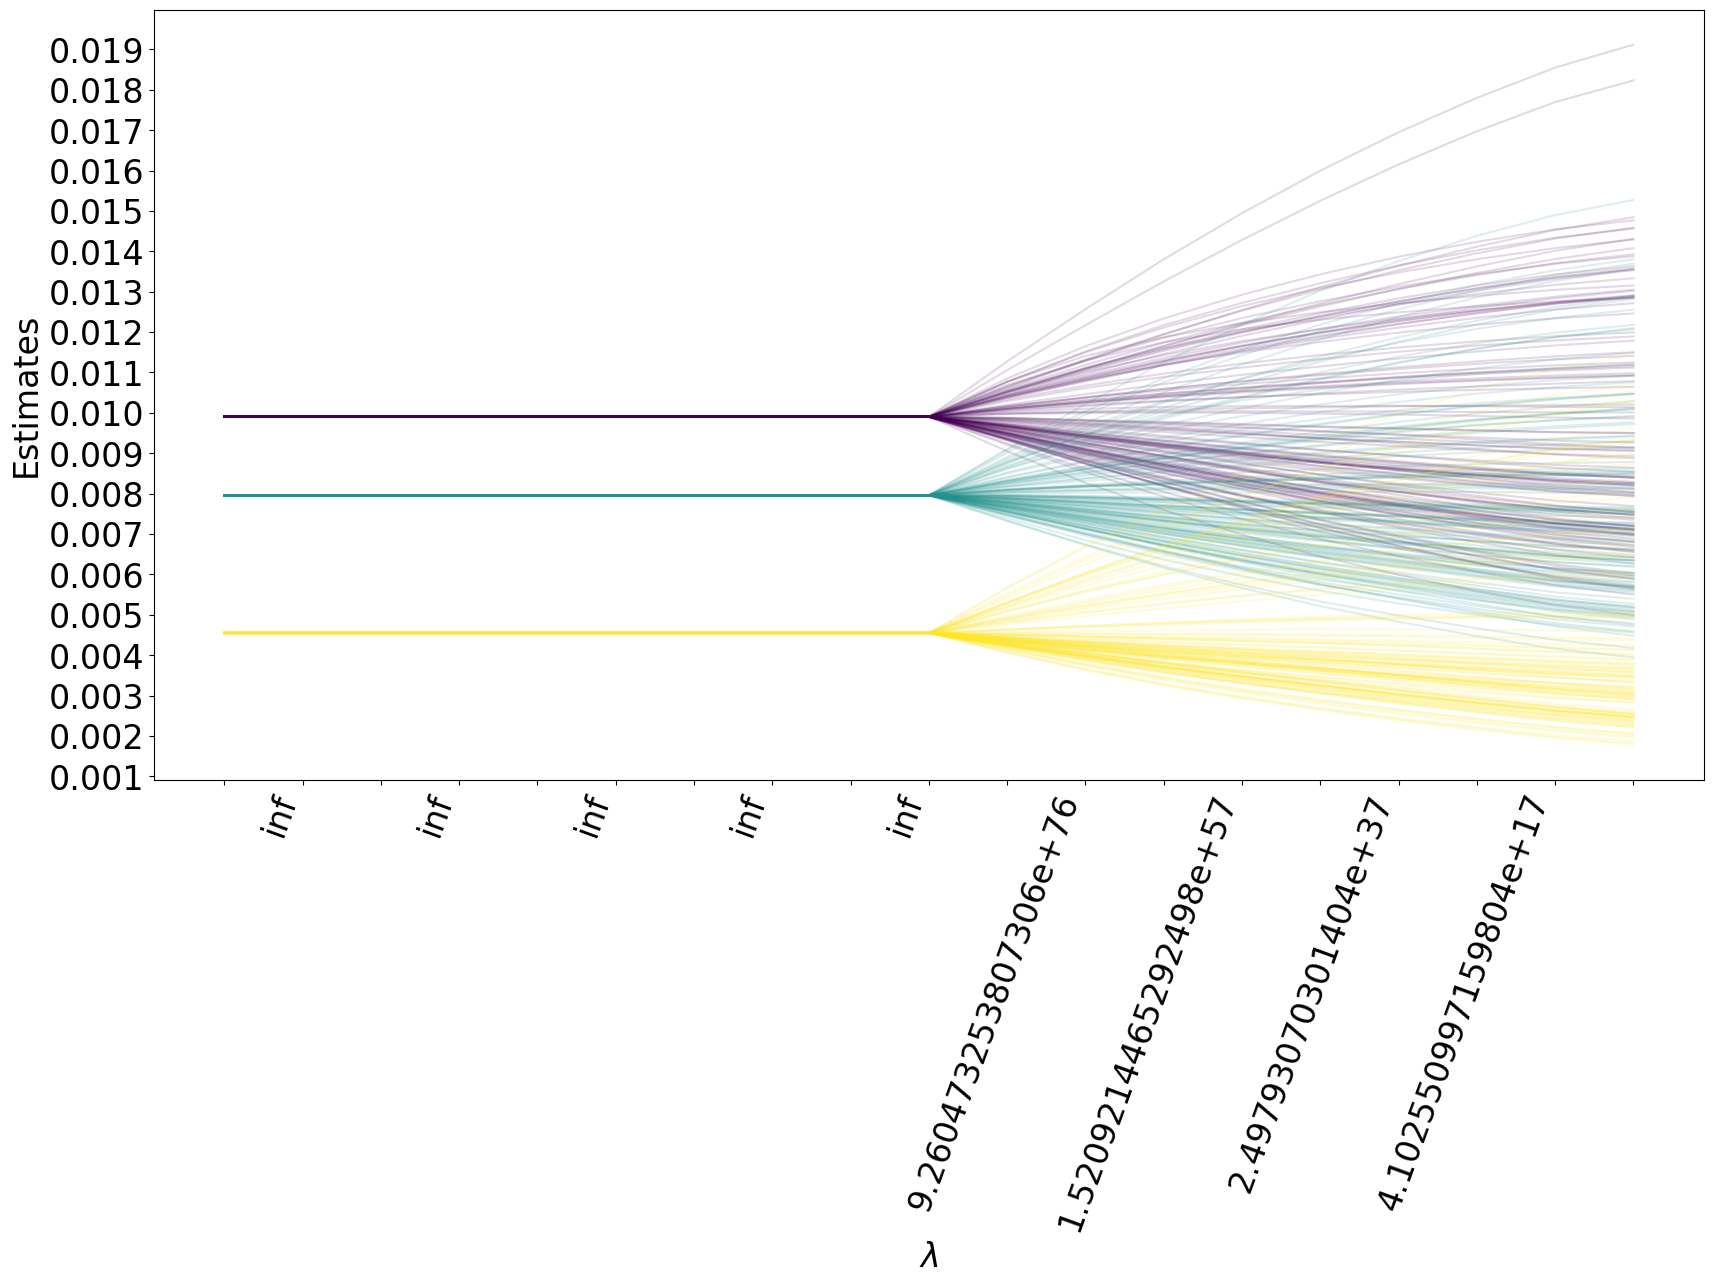

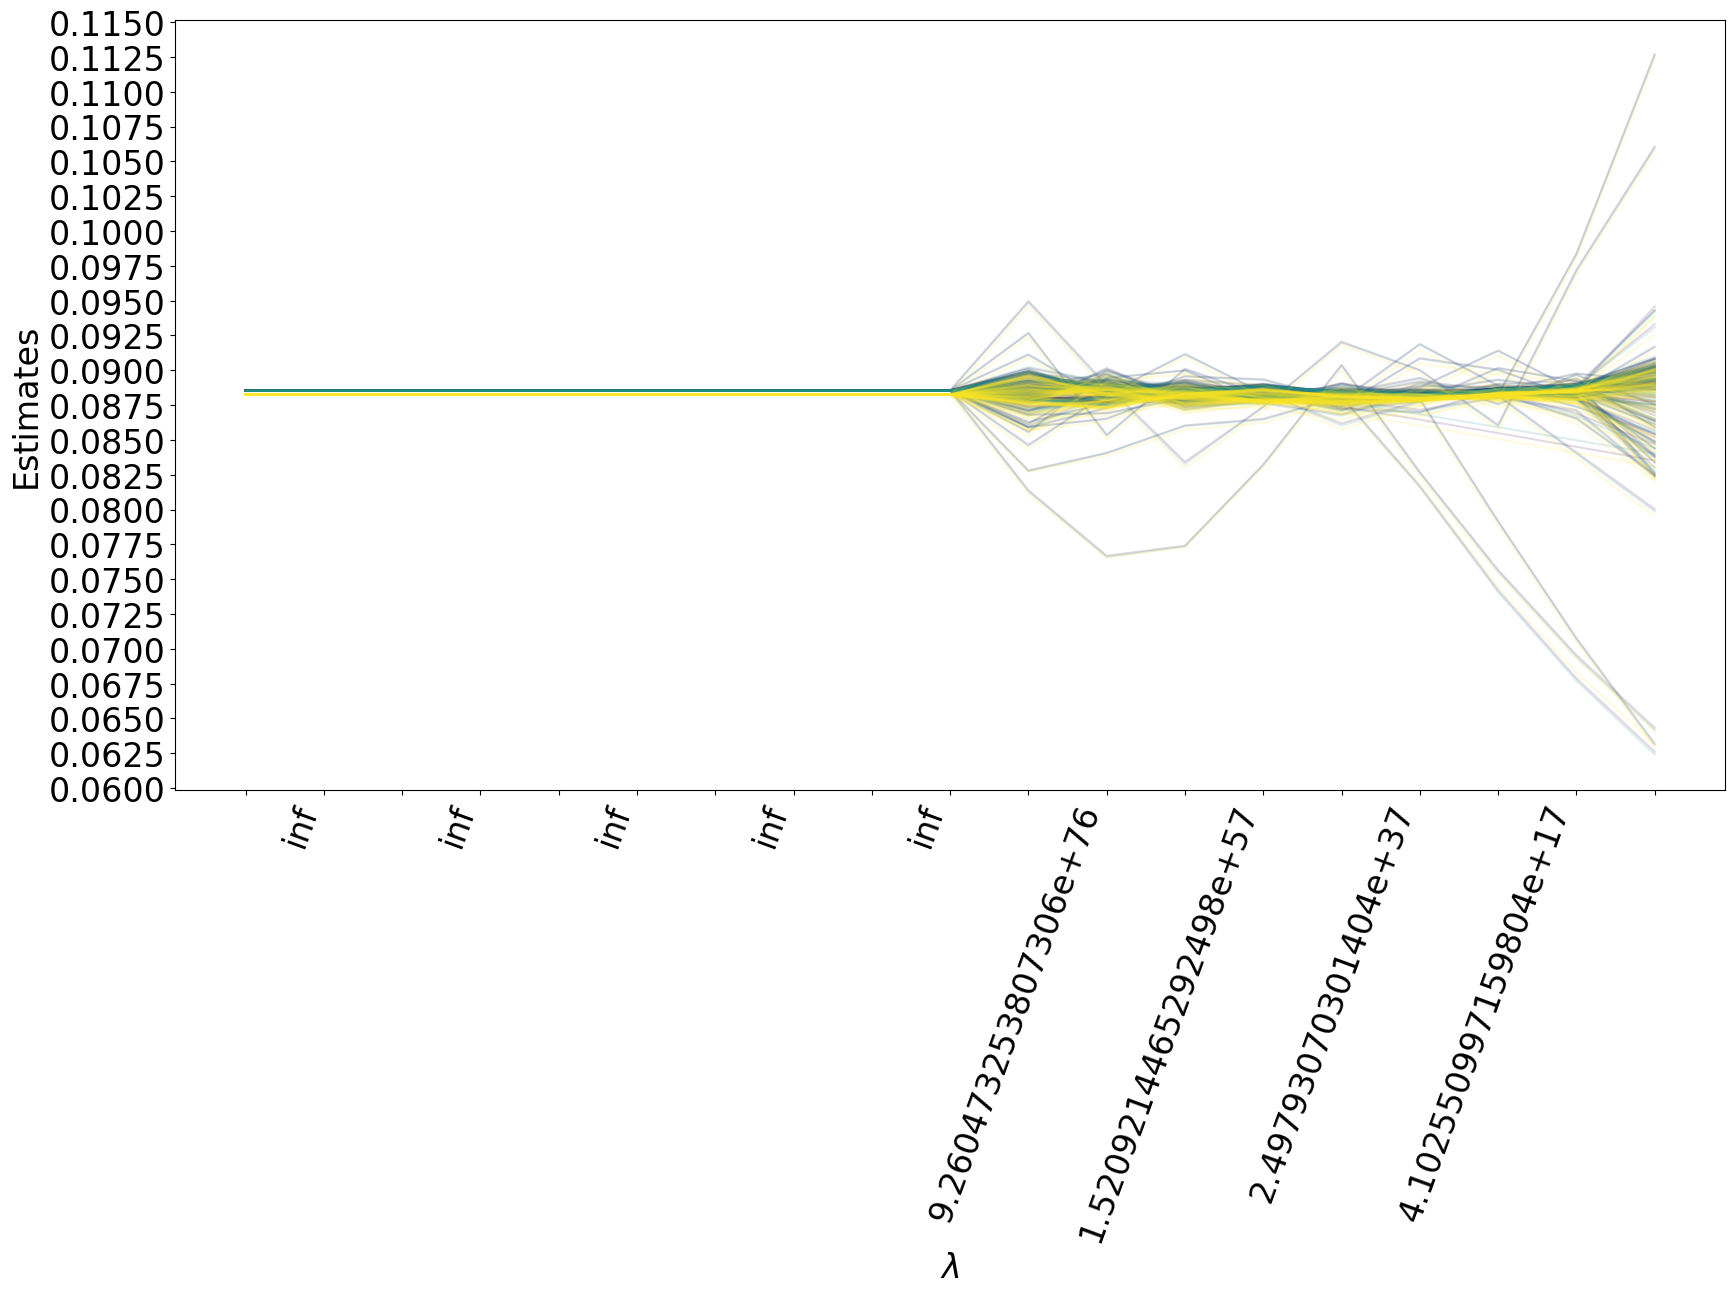

In [98]:
path_plot(np.asarray(U_list)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)

path_plot(np.asarray(V_list)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)




In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score

def fit_spectral(X, true_clusters, n_clusters):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors").fit(data_in)
    labels = spectral_clustering.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc


from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

def calculate_scores(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
    #
    return nmi_score, adj_rand_score, ri_score, mse_score

from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord


In [100]:

# from pcmf_neurips2022 import fit_spectral, confusion_matrix, calculate_scores, confusion_matrix_ordered

ari_list=[]
nmi_list=[]
acc_list=[]
for p in range(len(penalty_list)):
    labels, ari, nmi, acc = fit_spectral(np.hstack((np.array(U_list)[p,:,:],np.array(V_list)[p,:,:])), pd.factorize(true_clusters)[0], len(np.unique(true_clusters)))
    acc_list.append(acc)
    ari_list.append(ari)
    nmi_list.append(nmi)

['Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ACC:',np.max(np.array(acc_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list))]


['Best Penalty IDX:',
 17,
 'ACC:',
 0.972972972972973,
 'ARI:',
 0.9179264023008747,
 'NMI:',
 0.8973833461675936]